<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/BulkAnalyze_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_psinfo_welch(signal, nperseg):
  freqs, ps = scipy.signal.welch(
    signal, nperseg=nperseg, window='boxcar', detrend=False, scaling='spectrum')

  #due to the symmetry property of the fourier transform for real-valued signals,
  # certain frequencies in the power spectrum
  # for real inputs have their power doubled. But we are interested in how the power
  # spectrum differs from a uniform power spectrum, so we need to undo that
  # doubling. Reference: https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1900
  if nperseg%2: #if nperseg is odd
    ps[1:] /= 2
  else:
    ps[1:-1] /= 2

  ##Extract autocorrelation:
  autocovs = np.real(scipy.fft.irfft(ps*np.square(nperseg))) - ps[0]*nperseg #subtract ps[0]*nperseg to subtract (mean^2)*nperseg
  max_autocorr = np.max(autocovs[1:])/autocovs[0]

  return freqs, ps/np.sum(ps), max_autocorr

def max_over_different_smoothing_windows_1darr(arr, windowsizes):
  meannorm_arr = arr - np.mean(arr)
  meannormarr_cumsum = np.array([0] + list(np.cumsum(meannorm_arr)))
  #under the hypothesis of white noise, each entry is iid. Let v represent
  # the variance of each power. The variance of the sum in a window
  # is v*window, so the variances across different window sizes can be
  # normalized by dividing by sqrt(window).
  max_over_different_windowsizes = np.max([
      np.max((meannormarr_cumsum[windowsize:]
              - meannormarr_cumsum[:-windowsize]))/np.sqrt(windowsize)
      for windowsize in windowsizes])
  return max_over_different_windowsizes

def max_over_different_smoothing_windows_2darr(arrs, windowsizes):
  arrmeans = np.mean(arrs, axis=1)
  meannorm_arrs = arrs - arrmeans[:,None]
  meannormarrs_cumsum = np.pad(np.cumsum(meannorm_arrs, axis=1), ((0,0),(1,0)))
  max_over_different_windowsizes_arr = np.max([
      np.max((meannormarrs_cumsum[:,windowsize:]
              - meannormarrs_cumsum[:,:-windowsize]), axis=1)/np.sqrt(windowsize)
      for windowsize in windowsizes], axis=0)
  return max_over_different_windowsizes_arr

def perform_powerspectrum_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  #print("cp0", time.time()-start)
  for (nperseg, npersegname) in [(len(values), "NA"),
                                 (60*60, "60min")
                                 ]:
    nperseg_saveprefix = saveprefix+"_nperseg-"+npersegname

    freqs, nps, max_autocorr = get_psinfo_welch(values, nperseg)
    entropy_nps = scipy.stats.entropy(nps)

    #permute the test data sequence num_permutations times to get an empirical null
    psinfos_permute = [ get_psinfo_welch(rng_permutation, nperseg)
                        for rng_permutation in rng_permutations ]

    nps_permute_2darr = np.array([ psinfo[1] for psinfo in psinfos_permute])
    maxautocorr_permute_arr = np.array([psinfo[2] for psinfo in psinfos_permute])
    entropy_nps_permute_arr = scipy.stats.entropy(nps_permute_2darr, axis=1)

    pval_maxautocorr = np.mean(maxautocorr_permute_arr >= max_autocorr)
    toreturndict['pval_nperseg-'+npersegname+'_maxautocorr'] = pval_maxautocorr
    toreturndict['val_nperseg-'+npersegname+'_maxautocorr'] = max_autocorr

    pval_entropy = np.mean(entropy_nps <= entropy_nps_permute_arr) #high entropy = uniform dist
    toreturndict['pval_nperseg-'+npersegname+'_entropy'] = pval_entropy

    uniform_expectation = 1.0/len(nps)

    expected_freq = np.sum(freqs*nps)
    expected_freq_permute_arr = np.sum(freqs[None,:]*nps_permute_2darr, axis=1)
    pval_ef = np.mean(expected_freq_permute_arr >= expected_freq)
    toreturndict['pval_nperseg-'+npersegname+'_ef'] = pval_ef

    maxd = np.max(np.abs(np.cumsum(nps - uniform_expectation)))
    maxd_permute_arr = np.max(np.abs(np.cumsum(nps_permute_2darr - uniform_expectation, axis=1)), axis=1);
    pval_maxd = np.mean(maxd_permute_arr >= maxd)
    toreturndict['pval_nperseg-'+npersegname+'_maxd'] = pval_maxd

    freq_stepsize = freqs[1]
    for smoothfreqwindows, smoothfreqwindowsname in [([x/10000 for x in range(50, 501, 25)], '50-500-25'),
                                                     ([x/10000 for x in range(100, 151, 25)], '100-150-25'),
                                                     ([x/10000 for x in range(125, 126, 25)], '125-125-25')]:
      windowsizes = [int(x/freq_stepsize) for x in smoothfreqwindows]
      max_smooth_nps = max_over_different_smoothing_windows_1darr(nps, windowsizes)
      max_smooth_nps_permute_2darr = max_over_different_smoothing_windows_2darr(
          nps_permute_2darr, windowsizes)
      pval_max_smooth = np.mean(max_smooth_nps_permute_2darr >= max_smooth_nps)
      toreturndict['pval_nperseg-'+npersegname+'_smooth'+smoothfreqwindowsname+'_maxsmooth'] = pval_max_smooth

  return (toreturndict, (freqs, nps))



In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [5]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
                   "control4": [], "control5": [], "control6": []}
#compositez_psanalysis = {"test": [], "control1": [], "control2": [],
#                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/cache_v20231027/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3',
                           'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [("csm1", csm1, csm1_psanalysis),
                                             #("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis, _ = perform_powerspectrum_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)


Streaming output truncated to the last 5000 lines.
control4 {'csm1_zscore': -1.2359766823030487, 'length': 86400}
csm1 {'pval_nperseg-NA_maxautocorr': 0.311, 'val_nperseg-NA_maxautocorr': 0.01481836750294335, 'pval_nperseg-NA_entropy': 0.504, 'pval_nperseg-NA_ef': 0.056, 'pval_nperseg-NA_maxd': 0.035, 'pval_nperseg-NA_smooth50-500-25_maxsmooth': 0.315, 'pval_nperseg-NA_smooth100-150-25_maxsmooth': 0.12, 'pval_nperseg-NA_smooth125-125-25_maxsmooth': 0.401, 'pval_nperseg-60min_maxautocorr': 0.573, 'val_nperseg-60min_maxautocorr': 0.00998994138510058, 'pval_nperseg-60min_entropy': 0.864, 'pval_nperseg-60min_ef': 0.045, 'pval_nperseg-60min_maxd': 0.03, 'pval_nperseg-60min_smooth50-500-25_maxsmooth': 0.199, 'pval_nperseg-60min_smooth100-150-25_maxsmooth': 0.084, 'pval_nperseg-60min_smooth125-125-25_maxsmooth': 0.291} 0.19962453842163086
span: control5
control5 {'csm1_zscore': -1.552062926392241, 'length': 86400}
csm1 {'pval_nperseg-NA_maxautocorr': 0.938, 'val_nperseg-NA_maxautocorr': 0.013

In [6]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_smartersmooth_controls1to6"

#save the results
open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
#open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

2524460

In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [6]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_smartersmooth_controls1to6"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
#compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [7]:
def get_cdf_plotvals(pvals):
  floored_pvals = np.minimum(np.maximum(pvals, 1/NUM_PERMUTATIONS), 1-(1/NUM_PERMUTATIONS))
  pvals_to_zscores = sorted(scipy.stats.norm.ppf(1-floored_pvals))
  empirical_cdf = (np.arange(len(pvals_to_zscores))-1)/len(pvals_to_zscores)
  theoretical_cdf = scipy.stats.norm.cdf(pvals_to_zscores)
  return pvals_to_zscores, empirical_cdf, theoretical_cdf

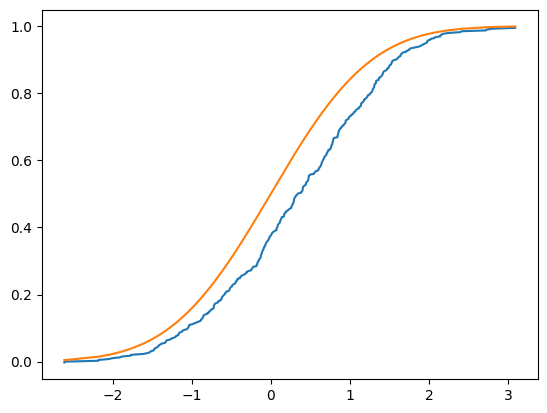

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

pvals_to_zscores, empirical_cdf, theoretical_cdf = get_cdf_plotvals([x[2] for x in event_metadata_list])
plt.plot(pvals_to_zscores, empirical_cdf)
plt.plot(pvals_to_zscores, theoretical_cdf)
plt.show()

In [9]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(csm1_psanalysis["test"])),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [10]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(csm1_psanalysis["test"]) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper left", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
nperseg-NA_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5574885022995401
Rankbias p-value: Original Timeperiod pval: 0.4437723795860199
meta-analysis p-value: 1x before pval: 0.32373525294941013
Rankbias p-value: 1x before pval: 0.599187879923117
meta-analysis p-value: 1x after pval: 0.6102779444111178
Rankbias p-value: 1x after pval: 0.9112789689846293
meta-analysis p-value: 2x before pval: 0.29454109178164367
Rankbias p-value: 2x before pval: 0.19949257345683924
meta-analysis p-value: 2x after pval: 0.7766446710657868
Rankbias p-value: 2x after pval: 0.7134043155768862
meta-analysis p-value: 3x before pval: 0.33813237352529496
Rankbias p-value: 3x before pval: 0.2719804623053281
meta-analysis p-value: 3x after pval: 0.9462107578484303
Rankbias p-value: 3x after pval: 0.8197387355365766


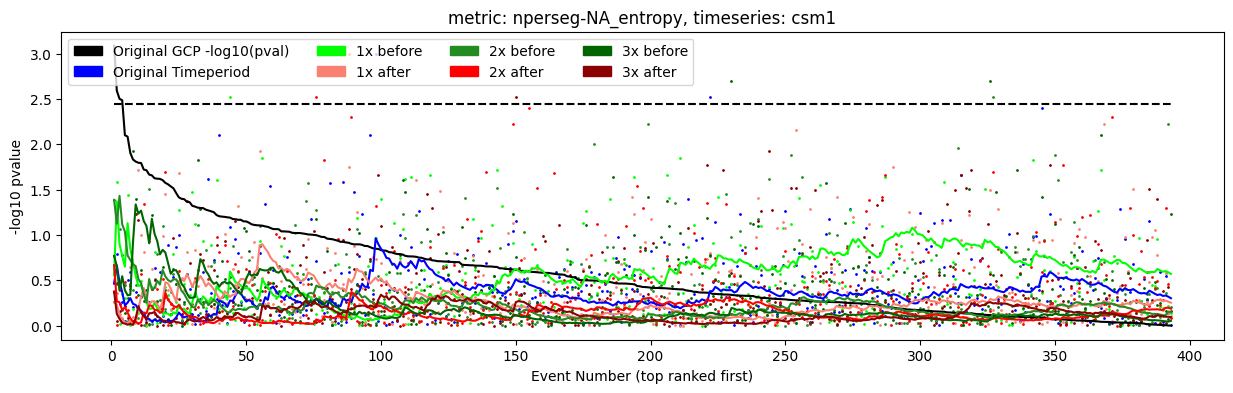

nperseg-60min_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.529494101179764
Rankbias p-value: Original Timeperiod pval: 0.29902581597248074
meta-analysis p-value: 1x before pval: 0.737252549490102
Rankbias p-value: 1x before pval: 0.698427068754675
meta-analysis p-value: 1x after pval: 0.9156168766246751
Rankbias p-value: 1x after pval: 0.7905113245790204
meta-analysis p-value: 2x before pval: 0.35012997400519896
Rankbias p-value: 2x before pval: 0.22950878071505154
meta-analysis p-value: 2x after pval: 0.4673065386922616
Rankbias p-value: 2x after pval: 0.8232029576397017
meta-analysis p-value: 3x before pval: 0.7536492701459709
Rankbias p-value: 3x before pval: 0.881505870928706
meta-analysis p-value: 3x after pval: 0.0621875624875025
Rankbias p-value: 3x after pval: 0.9584195322150961


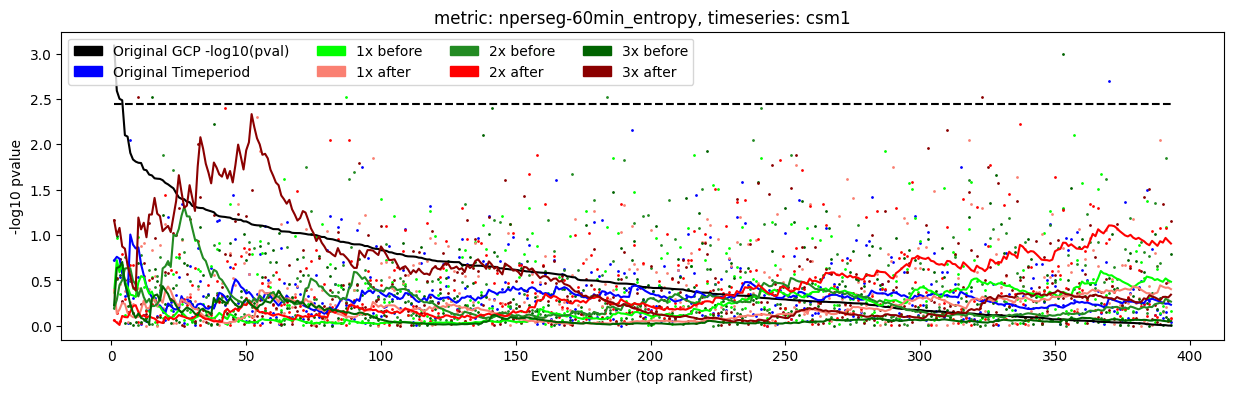

nperseg-NA_maxautocorr
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.22235552889422117
Rankbias p-value: Original Timeperiod pval: 0.14879966764974095
meta-analysis p-value: 1x before pval: 0.07818436312737452
Rankbias p-value: 1x before pval: 0.8193776518720987
meta-analysis p-value: 1x after pval: 0.6842631473705258
Rankbias p-value: 1x after pval: 0.4250439467960059
meta-analysis p-value: 2x before pval: 0.45310937812437513
Rankbias p-value: 2x before pval: 0.43565073761016515
meta-analysis p-value: 2x after pval: 0.2803439312137572
Rankbias p-value: 2x after pval: 0.9751669378028364
meta-analysis p-value: 3x before pval: 0.5032993401319736
Rankbias p-value: 3x before pval: 0.6111683179852685
meta-analysis p-value: 3x after pval: 0.124375124975005
Rankbias p-value: 3x after pval: 0.08842723193482144


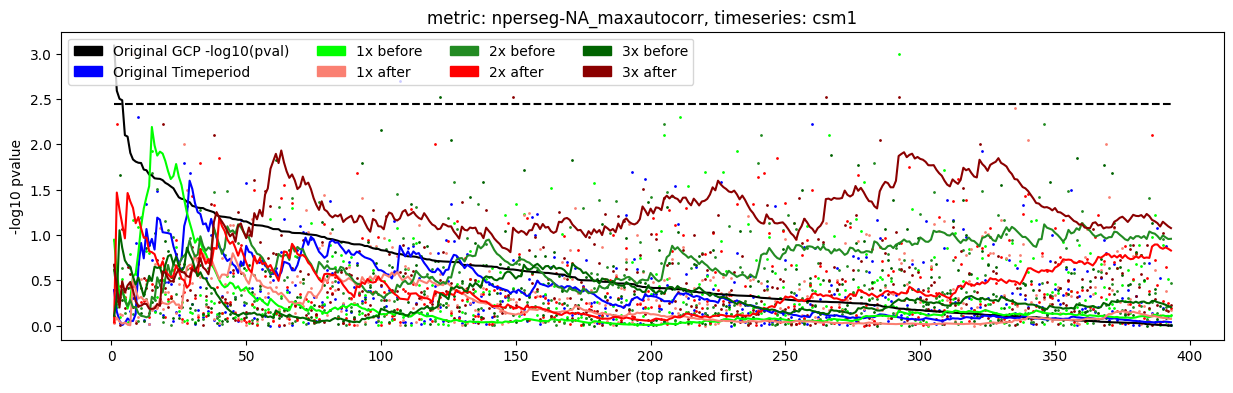

nperseg-60min_maxautocorr
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5062987402519497
Rankbias p-value: Original Timeperiod pval: 0.5704678567031028
meta-analysis p-value: 1x before pval: 0.266746650669866
Rankbias p-value: 1x before pval: 0.8139115957472605
meta-analysis p-value: 1x after pval: 0.6764647070585883
Rankbias p-value: 1x after pval: 0.14128943779284875
meta-analysis p-value: 2x before pval: 0.09798040391921616
Rankbias p-value: 2x before pval: 0.20361135432699862
meta-analysis p-value: 2x after pval: 0.39912017596480703
Rankbias p-value: 2x after pval: 0.3006166823641312
meta-analysis p-value: 3x before pval: 0.0621875624875025
Rankbias p-value: 3x before pval: 0.5663305249590906
meta-analysis p-value: 3x after pval: 0.47530493901219756
Rankbias p-value: 3x after pval: 0.31591543787917453


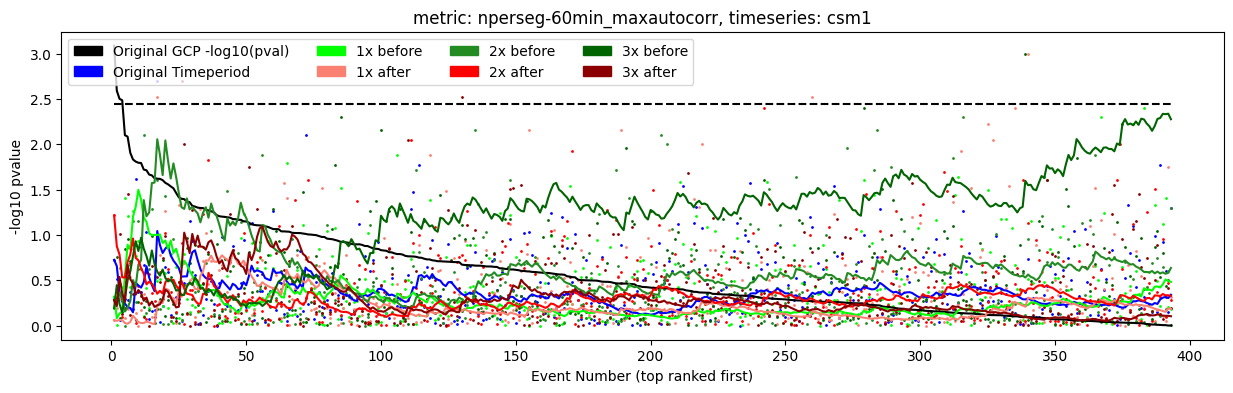

nperseg-NA_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.08458308338332333
Rankbias p-value: Original Timeperiod pval: 0.39833737089192084
meta-analysis p-value: 1x before pval: 0.7256548690261948
Rankbias p-value: 1x before pval: 0.45972008957510785
meta-analysis p-value: 1x after pval: 0.2575484903019396
Rankbias p-value: 1x after pval: 0.9295214925054929
meta-analysis p-value: 2x before pval: 0.6376724655068985
Rankbias p-value: 2x before pval: 0.9538326786741934
meta-analysis p-value: 2x after pval: 0.48050389922015596
Rankbias p-value: 2x after pval: 0.577465290933163
meta-analysis p-value: 3x before pval: 0.6374725054989002
Rankbias p-value: 3x before pval: 0.8747508480659731
meta-analysis p-value: 3x after pval: 0.34273145370925817
Rankbias p-value: 3x after pval: 0.21332861141428794


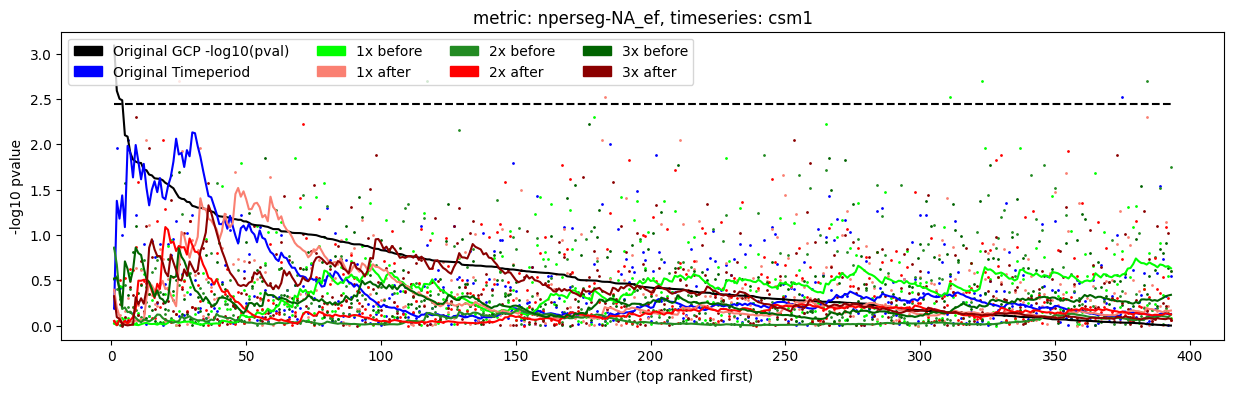

nperseg-60min_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.02559488102379524
Rankbias p-value: Original Timeperiod pval: 0.37695606244509855
meta-analysis p-value: 1x before pval: 0.8152369526094781
Rankbias p-value: 1x before pval: 0.569029656467806
meta-analysis p-value: 1x after pval: 0.3365326934613077
Rankbias p-value: 1x after pval: 0.8811425740804453
meta-analysis p-value: 2x before pval: 0.6412717456508699
Rankbias p-value: 2x before pval: 0.9502265857200209
meta-analysis p-value: 2x after pval: 0.5486902619476105
Rankbias p-value: 2x after pval: 0.3895335184458426
meta-analysis p-value: 3x before pval: 0.5236952609478104
Rankbias p-value: 3x before pval: 0.9141123172397142
meta-analysis p-value: 3x after pval: 0.24595080983803239
Rankbias p-value: 3x after pval: 0.1751394260146632


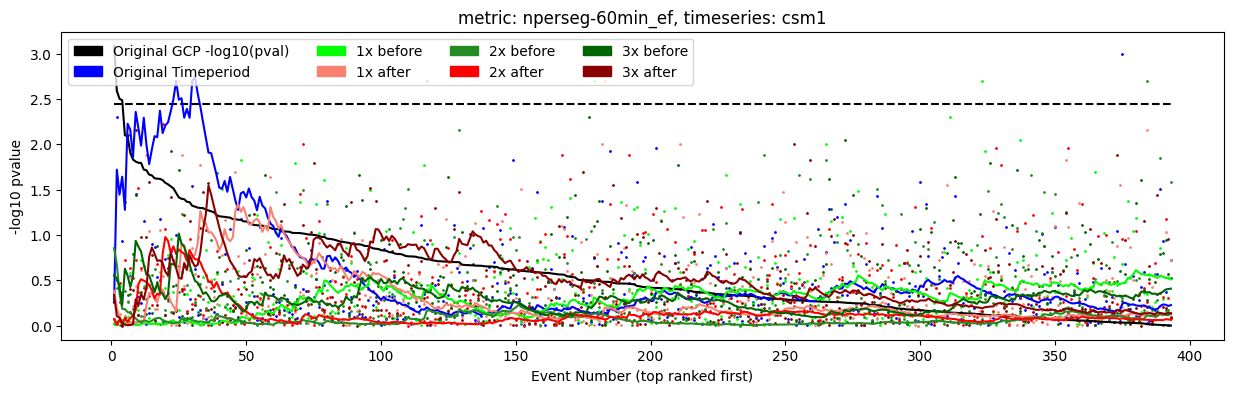

nperseg-NA_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.23635272945410918
Rankbias p-value: Original Timeperiod pval: 0.46190034176173245
meta-analysis p-value: 1x before pval: 0.4931013797240552
Rankbias p-value: 1x before pval: 0.40737103333514774
meta-analysis p-value: 1x after pval: 0.21555688862227554
Rankbias p-value: 1x after pval: 0.3554341132525145
meta-analysis p-value: 2x before pval: 0.4351129774045191
Rankbias p-value: 2x before pval: 0.9329752547318875
meta-analysis p-value: 2x after pval: 0.4411117776444711
Rankbias p-value: 2x after pval: 0.1616759665171449
meta-analysis p-value: 3x before pval: 0.7056588682263547
Rankbias p-value: 3x before pval: 0.9172964092383675
meta-analysis p-value: 3x after pval: 0.40371925614877024
Rankbias p-value: 3x after pval: 0.3664006930537403


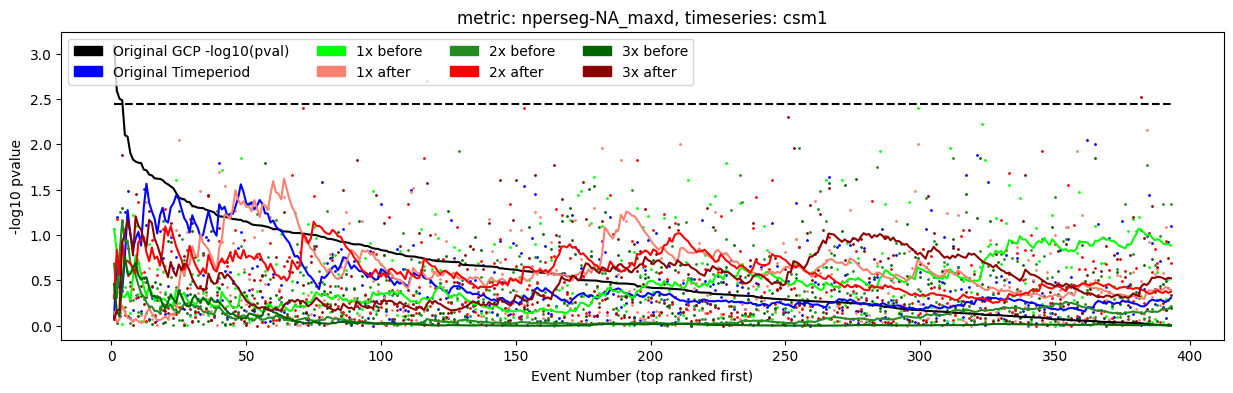

nperseg-60min_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.20855828834233153
Rankbias p-value: Original Timeperiod pval: 0.46480917784461195
meta-analysis p-value: 1x before pval: 0.4215156968606279
Rankbias p-value: 1x before pval: 0.3023707897794893
meta-analysis p-value: 1x after pval: 0.1239752049590082
Rankbias p-value: 1x after pval: 0.37088798590940764
meta-analysis p-value: 2x before pval: 0.4107178564287143
Rankbias p-value: 2x before pval: 0.9528501245685111
meta-analysis p-value: 2x after pval: 0.5338932213557289
Rankbias p-value: 2x after pval: 0.18170737640217738
meta-analysis p-value: 3x before pval: 0.7408518296340731
Rankbias p-value: 3x before pval: 0.8733303633482046
meta-analysis p-value: 3x after pval: 0.47130573885222954
Rankbias p-value: 3x after pval: 0.3213060981656454


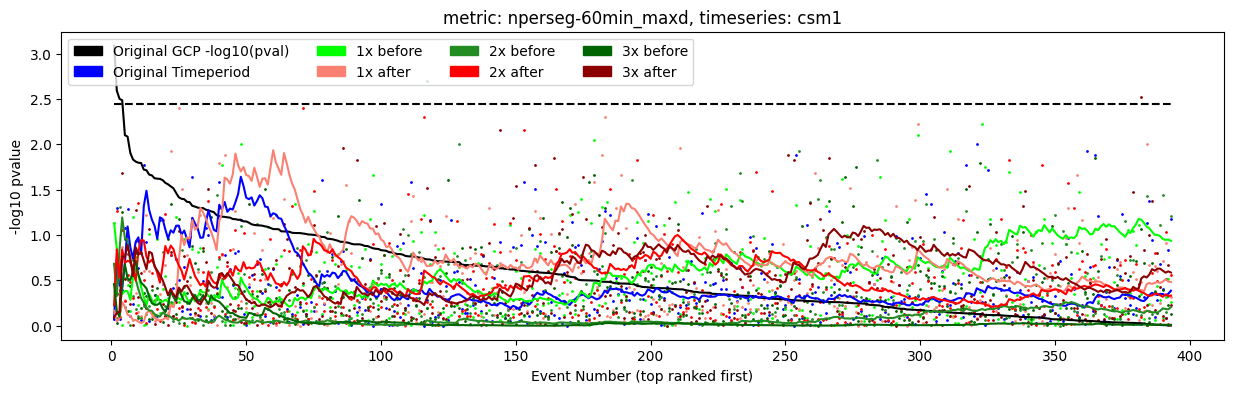

nperseg-NA_smooth50-500-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.3007398520295941
Rankbias p-value: Original Timeperiod pval: 0.3355305023505637
meta-analysis p-value: 1x before pval: 0.8694261147770446
Rankbias p-value: 1x before pval: 0.9828528751913802
meta-analysis p-value: 1x after pval: 0.15956808638272343
Rankbias p-value: 1x after pval: 0.2619011383259038
meta-analysis p-value: 2x before pval: 0.735252949410118
Rankbias p-value: 2x before pval: 0.6887899570728128
meta-analysis p-value: 2x after pval: 0.3127374525094981
Rankbias p-value: 2x after pval: 0.8030561354448765
meta-analysis p-value: 3x before pval: 0.9142171565686863
Rankbias p-value: 3x before pval: 0.18413317899726767
meta-analysis p-value: 3x after pval: 0.6938612277544491
Rankbias p-value: 3x after pval: 0.6709507937261716


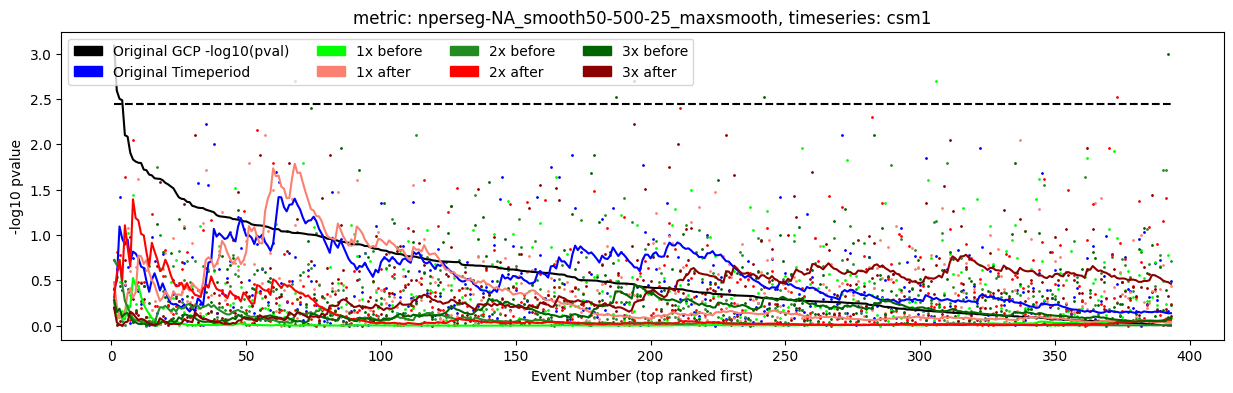

nperseg-60min_smooth50-500-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.35892821435712857
Rankbias p-value: Original Timeperiod pval: 0.6496663794205617
meta-analysis p-value: 1x before pval: 0.35912817436512695
Rankbias p-value: 1x before pval: 0.9065557158538528
meta-analysis p-value: 1x after pval: 0.06818636272745451
Rankbias p-value: 1x after pval: 0.5062072303117425
meta-analysis p-value: 2x before pval: 0.4999000199960008
Rankbias p-value: 2x before pval: 0.6554141532896619
meta-analysis p-value: 2x after pval: 0.12577484503099381
Rankbias p-value: 2x after pval: 0.8043229181321299
meta-analysis p-value: 3x before pval: 0.9142171565686863
Rankbias p-value: 3x before pval: 0.13532979445735
meta-analysis p-value: 3x after pval: 0.904619076184763
Rankbias p-value: 3x after pval: 0.7429922598302677


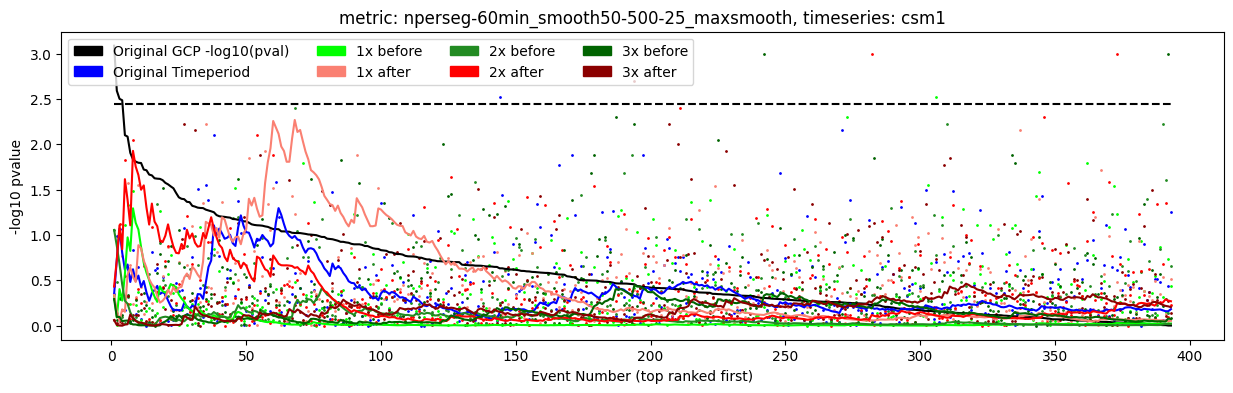

nperseg-NA_smooth100-150-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.03259348130373925
Rankbias p-value: Original Timeperiod pval: 0.20038920067301091
meta-analysis p-value: 1x before pval: 0.9422115576884623
Rankbias p-value: 1x before pval: 0.9817961012007398
meta-analysis p-value: 1x after pval: 0.5604879024195161
Rankbias p-value: 1x after pval: 0.2949079816915603
meta-analysis p-value: 2x before pval: 0.4699060187962408
Rankbias p-value: 2x before pval: 0.7733956556769853
meta-analysis p-value: 2x after pval: 0.5994801039792041
Rankbias p-value: 2x after pval: 0.9369221932289566
meta-analysis p-value: 3x before pval: 0.6860627874425116
Rankbias p-value: 3x before pval: 0.26190088186080923
meta-analysis p-value: 3x after pval: 0.9822035592881424
Rankbias p-value: 3x after pval: 0.9715909091404589


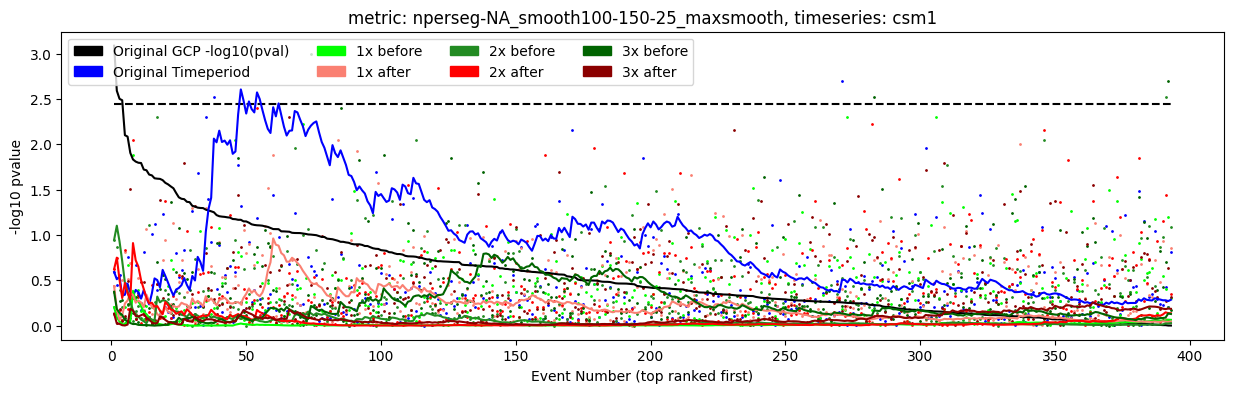

nperseg-60min_smooth100-150-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.022795440911817632
Rankbias p-value: Original Timeperiod pval: 0.7471068656161961
meta-analysis p-value: 1x before pval: 0.8902219556088782
Rankbias p-value: 1x before pval: 0.96277933456335
meta-analysis p-value: 1x after pval: 0.3509298140371926
Rankbias p-value: 1x after pval: 0.4775553700449891
meta-analysis p-value: 2x before pval: 0.3687262547490502
Rankbias p-value: 2x before pval: 0.38690319645901156
meta-analysis p-value: 2x after pval: 0.6676664667066586
Rankbias p-value: 2x after pval: 0.9432876707754754
meta-analysis p-value: 3x before pval: 0.8012397520495901
Rankbias p-value: 3x before pval: 0.09827059113495318
meta-analysis p-value: 3x after pval: 0.9530093981203759
Rankbias p-value: 3x after pval: 0.8389957095053656


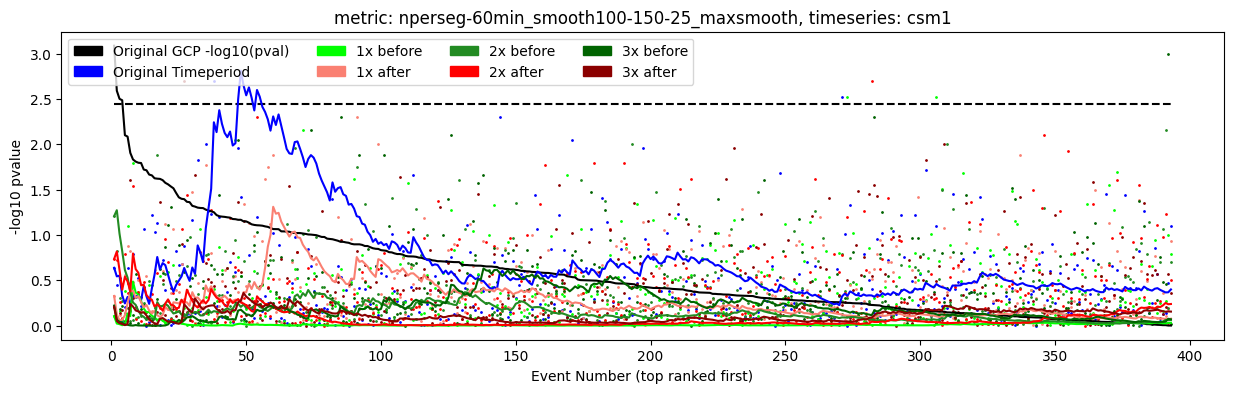

nperseg-NA_smooth125-125-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.004199160167966407
Rankbias p-value: Original Timeperiod pval: 0.5118654945043767
meta-analysis p-value: 1x before pval: 0.9554089182163568
Rankbias p-value: 1x before pval: 0.8439759187533511
meta-analysis p-value: 1x after pval: 0.5558888222355529
Rankbias p-value: 1x after pval: 0.595645960919168
meta-analysis p-value: 2x before pval: 0.47450509898020393
Rankbias p-value: 2x before pval: 0.6611262646754636
meta-analysis p-value: 2x after pval: 0.6560687862427514
Rankbias p-value: 2x after pval: 0.8590179789413223
meta-analysis p-value: 3x before pval: 0.4771045790841832
Rankbias p-value: 3x before pval: 0.071036219031663
meta-analysis p-value: 3x after pval: 0.9608078384323135
Rankbias p-value: 3x after pval: 0.9677951886013003


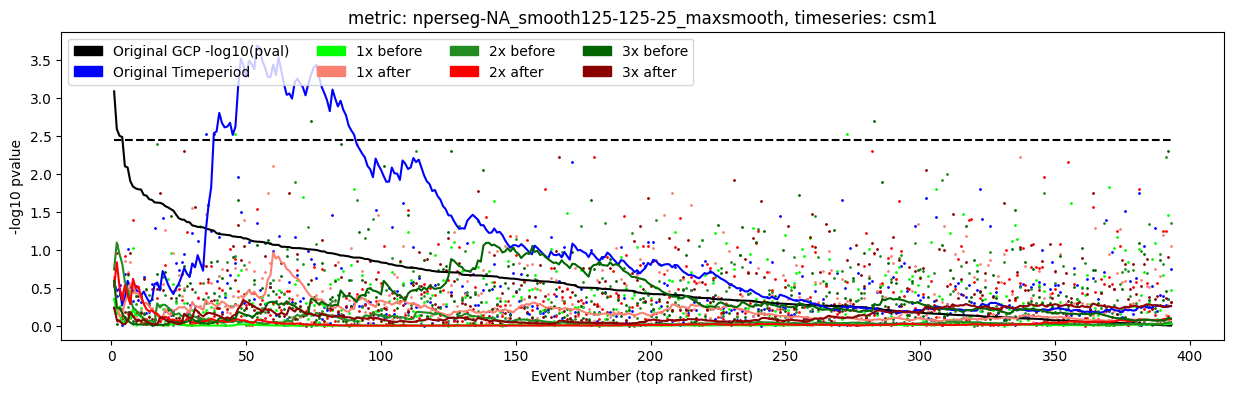

nperseg-60min_smooth125-125-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0033993201359728054
Rankbias p-value: Original Timeperiod pval: 0.8014015873923543
meta-analysis p-value: 1x before pval: 0.9926014797040592
Rankbias p-value: 1x before pval: 0.8232031241758944
meta-analysis p-value: 1x after pval: 0.34233153369326136
Rankbias p-value: 1x after pval: 0.5738797848313731
meta-analysis p-value: 2x before pval: 0.5072985402919417
Rankbias p-value: 2x before pval: 0.6216524406441751
meta-analysis p-value: 2x after pval: 0.6058788242351529
Rankbias p-value: 2x after pval: 0.8157450175480375
meta-analysis p-value: 3x before pval: 0.7034593081383723
Rankbias p-value: 3x before pval: 0.05345121606998458
meta-analysis p-value: 3x after pval: 0.8792241551689662
Rankbias p-value: 3x after pval: 0.8412215618431171


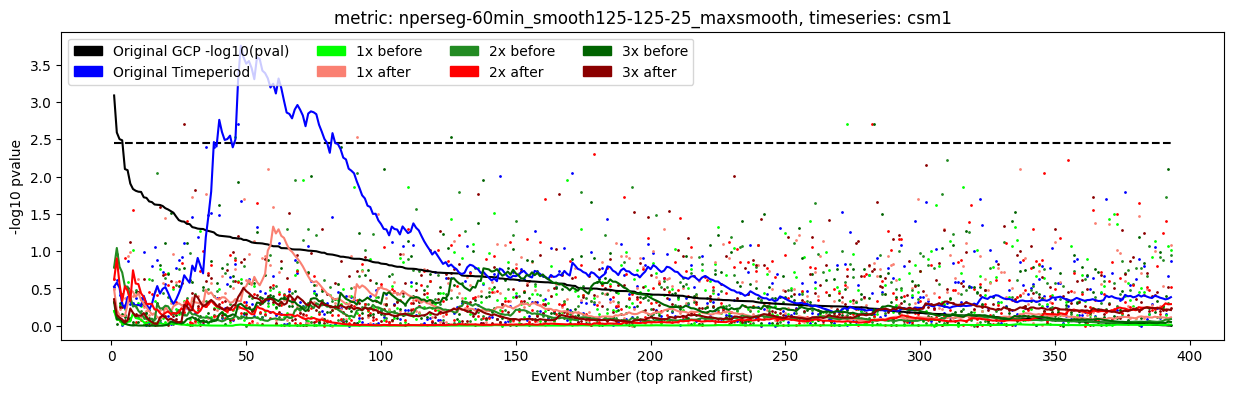

csm1
NEGATIVE nperseg-NA_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9708058388322336
Rankbias p-value: Original Timeperiod pval: 0.5565891103635712
meta-analysis p-value: 1x before pval: 0.07838432313537293
Rankbias p-value: 1x before pval: 0.4011659615709543
meta-analysis p-value: 1x after pval: 0.747250549890022
Rankbias p-value: 1x after pval: 0.08886818140884173
meta-analysis p-value: 2x before pval: 0.7450509898020395
Rankbias p-value: 2x before pval: 0.8007631814106289
meta-analysis p-value: 2x after pval: 0.10337932413517296
Rankbias p-value: 2x after pval: 0.28690733052376627
meta-analysis p-value: 3x before pval: 0.3719256148770246
Rankbias p-value: 3x before pval: 0.7283231937573151
meta-analysis p-value: 3x after pval: 0.08198360327934413
Rankbias p-value: 3x after pval: 0.1805017546640299


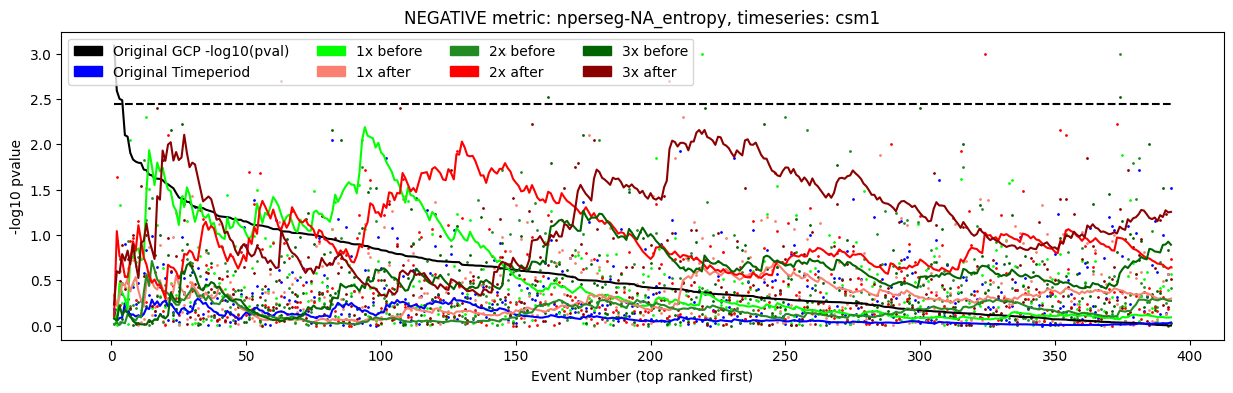

NEGATIVE nperseg-60min_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9130173965206959
Rankbias p-value: Original Timeperiod pval: 0.7012918764900339
meta-analysis p-value: 1x before pval: 0.4003199360127974
Rankbias p-value: 1x before pval: 0.30189199669428535
meta-analysis p-value: 1x after pval: 0.16756648670265947
Rankbias p-value: 1x after pval: 0.209752181335772
meta-analysis p-value: 2x before pval: 0.9164167166566687
Rankbias p-value: 2x before pval: 0.770768717175122
meta-analysis p-value: 2x after pval: 0.4947010597880424
Rankbias p-value: 2x after pval: 0.17703461228826312
meta-analysis p-value: 3x before pval: 0.21315736852629474
Rankbias p-value: 3x before pval: 0.11867569664982475
meta-analysis p-value: 3x after pval: 0.367126574685063
Rankbias p-value: 3x after pval: 0.041661925212765405


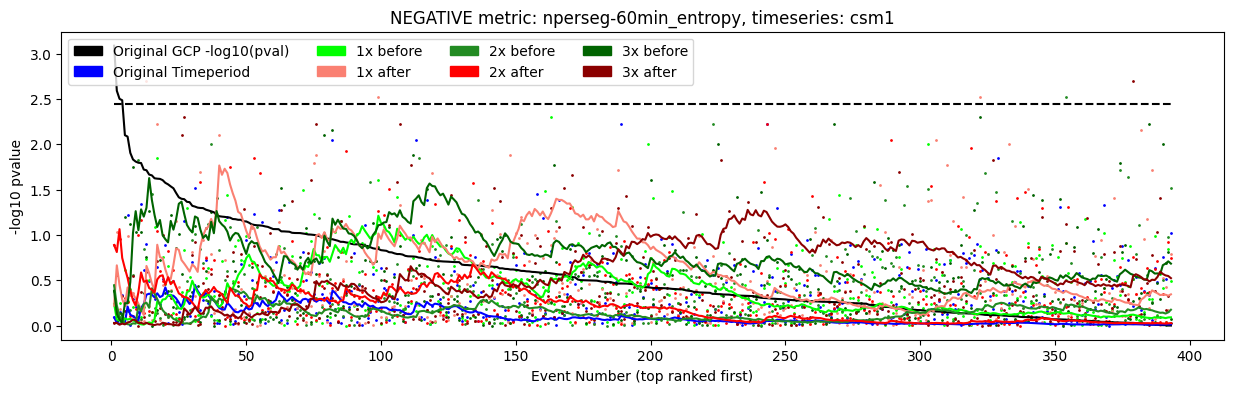

NEGATIVE nperseg-NA_maxautocorr
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.29994001199760045
Rankbias p-value: Original Timeperiod pval: 0.8514124965968839
meta-analysis p-value: 1x before pval: 0.6876624675064987
Rankbias p-value: 1x before pval: 0.18086313999672704
meta-analysis p-value: 1x after pval: 0.3619276144771046
Rankbias p-value: 1x after pval: 0.5753147036623327
meta-analysis p-value: 2x before pval: 0.9936012797440512
Rankbias p-value: 2x before pval: 0.5647096212939107
meta-analysis p-value: 2x after pval: 0.4939012197560488
Rankbias p-value: 2x after pval: 0.024886304194913837
meta-analysis p-value: 3x before pval: 0.6976604679064187
Rankbias p-value: 3x before pval: 0.38918260288769246
meta-analysis p-value: 3x after pval: 0.4969006198760248
Rankbias p-value: 3x after pval: 0.911719374137731


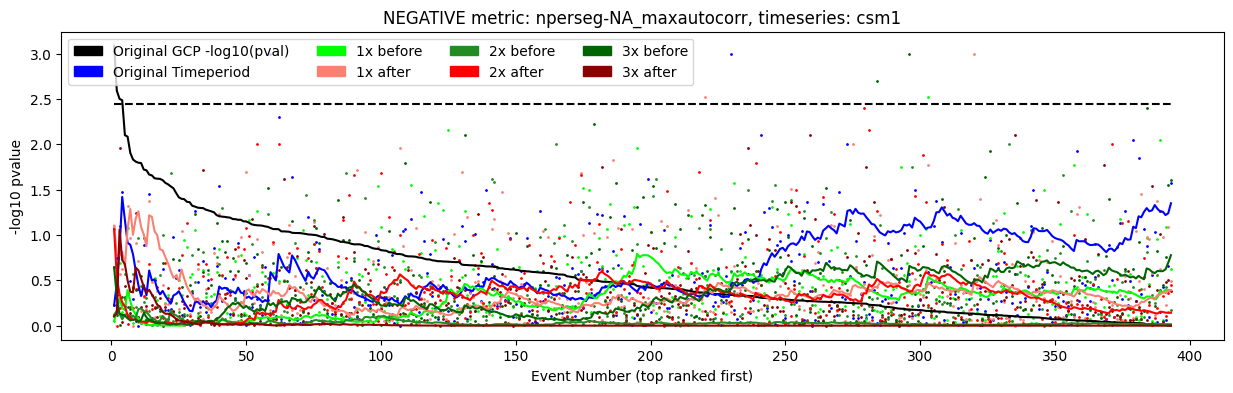

NEGATIVE nperseg-60min_maxautocorr
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9734053189362127
Rankbias p-value: Original Timeperiod pval: 0.42989160730486065
meta-analysis p-value: 1x before pval: 0.34933013397320534
Rankbias p-value: 1x before pval: 0.1863337120893857
meta-analysis p-value: 1x after pval: 0.41151769646070785
Rankbias p-value: 1x after pval: 0.8589154540267587
meta-analysis p-value: 2x before pval: 0.46170765846830636
Rankbias p-value: 2x before pval: 0.7966475531577945
meta-analysis p-value: 2x after pval: 0.8770245950809838
Rankbias p-value: 2x after pval: 0.6997017747193346
meta-analysis p-value: 3x before pval: 0.9186162767446511
Rankbias p-value: 3x before pval: 0.4340295896115728
meta-analysis p-value: 3x after pval: 0.08618276344731053
Rankbias p-value: 3x after pval: 0.6844100365849352


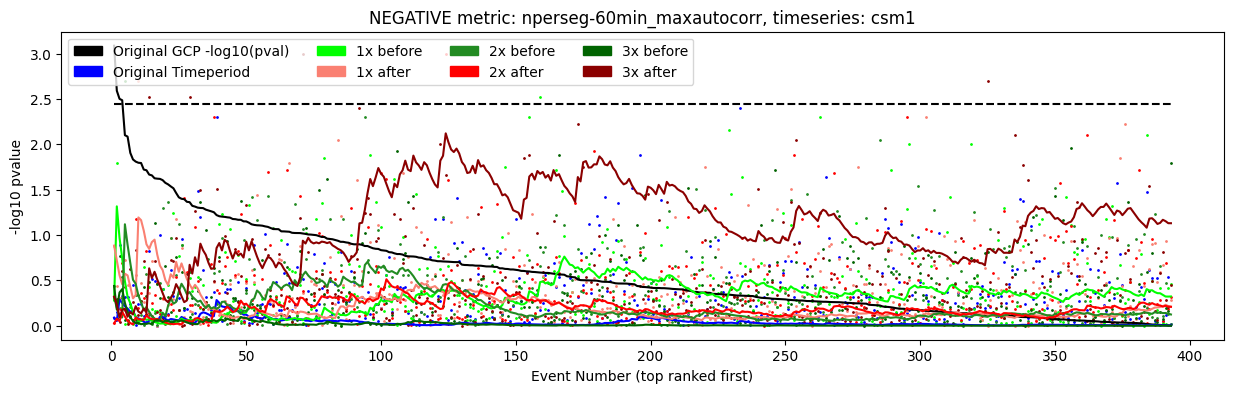

NEGATIVE nperseg-NA_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8102379524095181
Rankbias p-value: Original Timeperiod pval: 0.6020158124625583
meta-analysis p-value: 1x before pval: 0.28074385122975404
Rankbias p-value: 1x before pval: 0.5406431764150246
meta-analysis p-value: 1x after pval: 0.3527294541091782
Rankbias p-value: 1x after pval: 0.07060212978378677
meta-analysis p-value: 2x before pval: 0.3277344531093781
Rankbias p-value: 2x before pval: 0.04625595137081523
meta-analysis p-value: 2x after pval: 0.14637072585482905
Rankbias p-value: 2x after pval: 0.42289298116490753
meta-analysis p-value: 3x before pval: 0.6846630673865227
Rankbias p-value: 3x before pval: 0.1254379279376538
meta-analysis p-value: 3x after pval: 0.0597880423915217
Rankbias p-value: 3x after pval: 0.7869375172975294


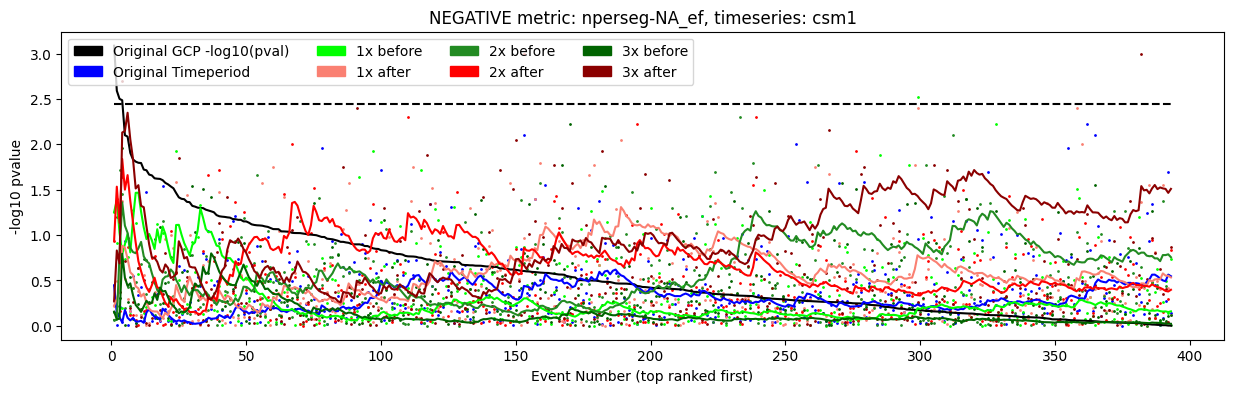

NEGATIVE nperseg-60min_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8212357528494301
Rankbias p-value: Original Timeperiod pval: 0.6233915252241085
meta-analysis p-value: 1x before pval: 0.2953409318136373
Rankbias p-value: 1x before pval: 0.43133003830479955
meta-analysis p-value: 1x after pval: 0.25394921015796845
Rankbias p-value: 1x after pval: 0.11903938650195656
meta-analysis p-value: 2x before pval: 0.36372725454909016
Rankbias p-value: 2x before pval: 0.0498675423039783
meta-analysis p-value: 2x after pval: 0.15756848630273948
Rankbias p-value: 2x after pval: 0.6108174931260526
meta-analysis p-value: 3x before pval: 0.663867226554689
Rankbias p-value: 3x before pval: 0.08603131161052369
meta-analysis p-value: 3x after pval: 0.08398320335932813
Rankbias p-value: 3x after pval: 0.8250965302017448


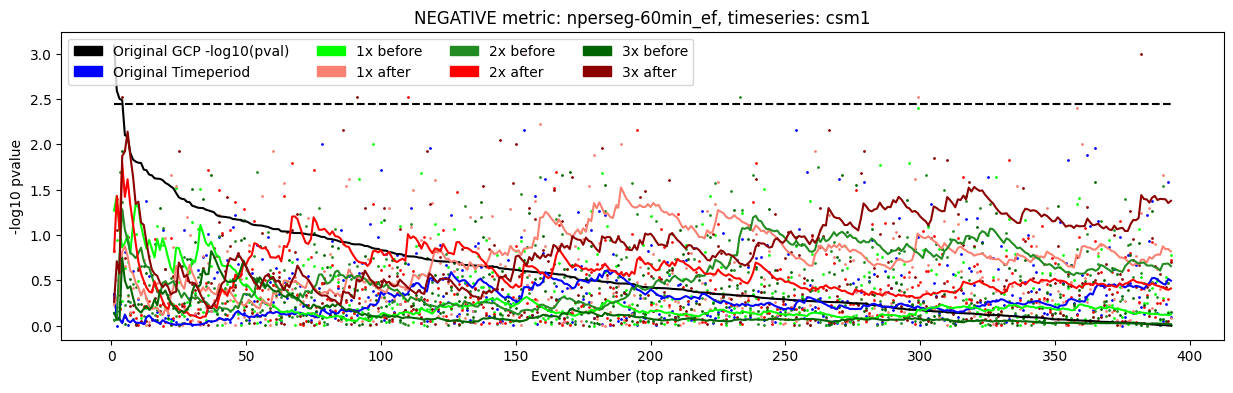

NEGATIVE nperseg-NA_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7674465106978604
Rankbias p-value: Original Timeperiod pval: 0.5384631218579327
meta-analysis p-value: 1x before pval: 0.6634673065386922
Rankbias p-value: 1x before pval: 0.5929841869410297
meta-analysis p-value: 1x after pval: 0.5232953409318136
Rankbias p-value: 1x after pval: 0.6449067294749231
meta-analysis p-value: 2x before pval: 0.8662267546490702
Rankbias p-value: 2x before pval: 0.06714367087018798
meta-analysis p-value: 2x after pval: 0.9728054389122176
Rankbias p-value: 2x after pval: 0.8385481520920431
meta-analysis p-value: 3x before pval: 0.2601479704059188
Rankbias p-value: 3x before pval: 0.08284320583378862
meta-analysis p-value: 3x after pval: 0.6596680663867227
Rankbias p-value: 3x after pval: 0.6339437275255686


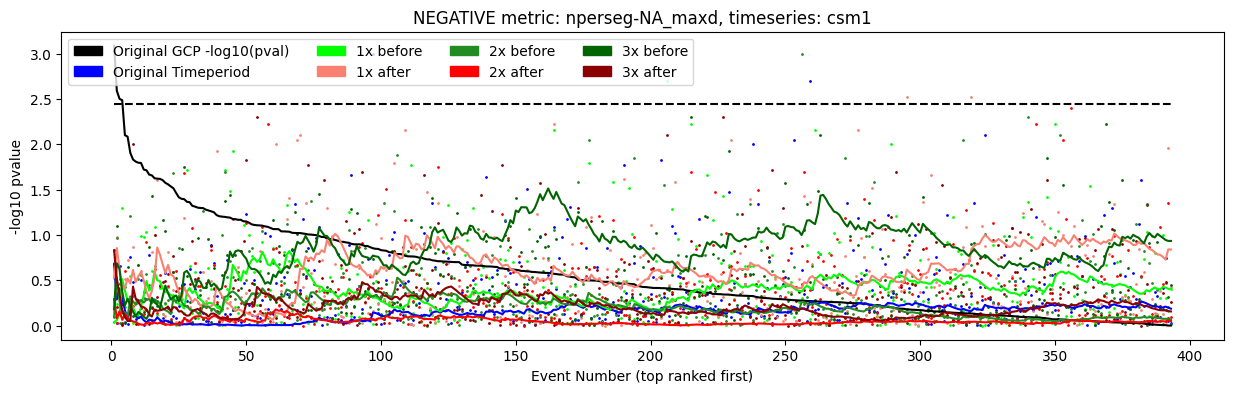

NEGATIVE nperseg-60min_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6518696260747852
Rankbias p-value: Original Timeperiod pval: 0.5355545318154256
meta-analysis p-value: 1x before pval: 0.6110777844431113
Rankbias p-value: 1x before pval: 0.6979485031009206
meta-analysis p-value: 1x after pval: 0.636872625474905
Rankbias p-value: 1x after pval: 0.6294578137319781
meta-analysis p-value: 2x before pval: 0.7730453909218157
Rankbias p-value: 2x before pval: 0.0472400153729206
meta-analysis p-value: 2x after pval: 0.9418116376724655
Rankbias p-value: 2x after pval: 0.8185341191875443
meta-analysis p-value: 3x before pval: 0.498500299940012
Rankbias p-value: 3x before pval: 0.12685990256617968
meta-analysis p-value: 3x after pval: 0.7476504699060188
Rankbias p-value: 3x after pval: 0.6790217051235988


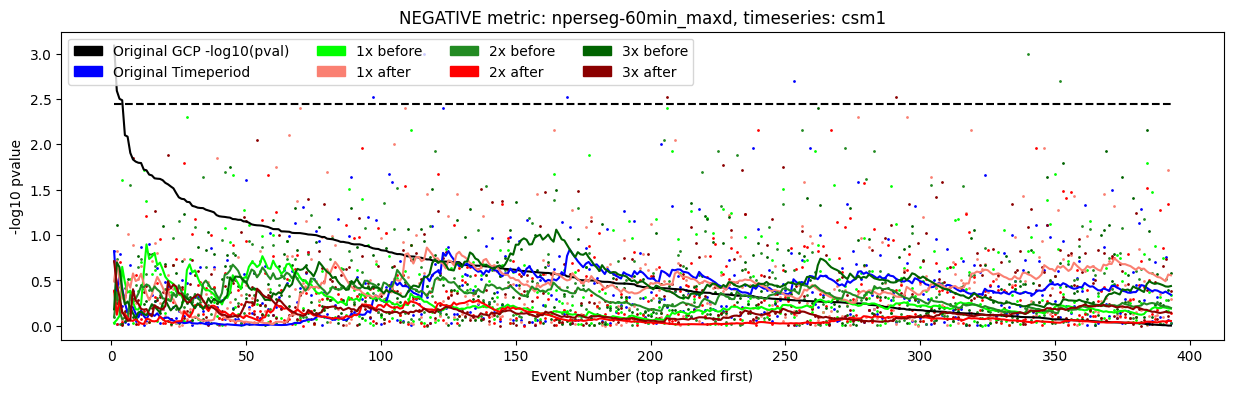

NEGATIVE nperseg-NA_smooth50-500-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5960807838432314
Rankbias p-value: Original Timeperiod pval: 0.6648030903589637
meta-analysis p-value: 1x before pval: 0.046390721855628876
Rankbias p-value: 1x before pval: 0.017186035846847657
meta-analysis p-value: 1x after pval: 0.6010797840431914
Rankbias p-value: 1x after pval: 0.7383967753747138
meta-analysis p-value: 2x before pval: 0.1259748050389922
Rankbias p-value: 2x before pval: 0.31153356969864143
meta-analysis p-value: 2x after pval: 0.14237152569486103
Rankbias p-value: 2x after pval: 0.19719783907716948
meta-analysis p-value: 3x before pval: 0.4313137372525495
Rankbias p-value: 3x before pval: 0.8161103247879113
meta-analysis p-value: 3x after pval: 0.046390721855628876
Rankbias p-value: 3x after pval: 0.32938035846177505


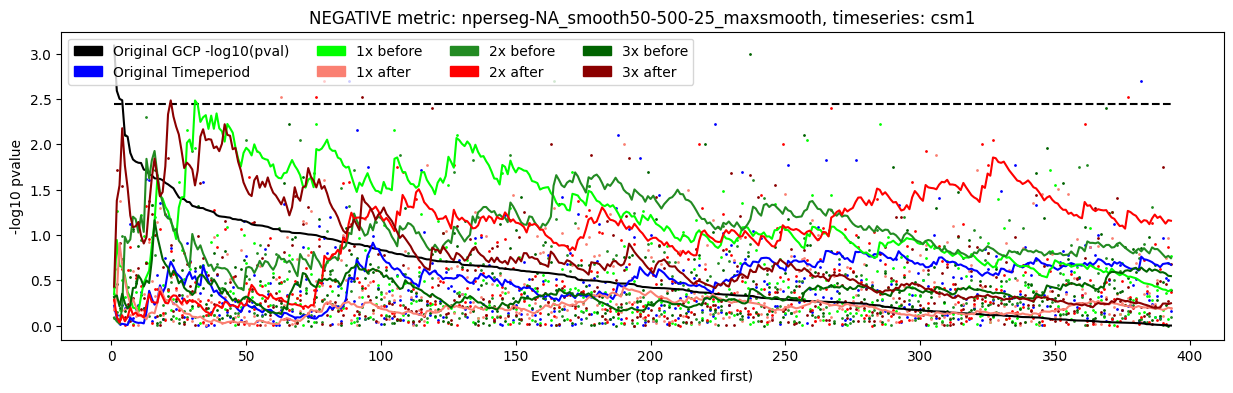

NEGATIVE nperseg-60min_smooth50-500-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.03799240151969606
Rankbias p-value: Original Timeperiod pval: 0.35067281856966015
meta-analysis p-value: 1x before pval: 0.3317336532693461
Rankbias p-value: 1x before pval: 0.09359720363352303
meta-analysis p-value: 1x after pval: 0.6580683863227355
Rankbias p-value: 1x after pval: 0.4941578739657231
meta-analysis p-value: 2x before pval: 0.34453109378124375
Rankbias p-value: 2x before pval: 0.3449229831583756
meta-analysis p-value: 2x after pval: 0.20655868826234752
Rankbias p-value: 2x after pval: 0.19593006520862843
meta-analysis p-value: 3x before pval: 0.15216956608678264
Rankbias p-value: 3x before pval: 0.864869163121243
meta-analysis p-value: 3x after pval: 0.07698460307938411
Rankbias p-value: 3x after pval: 0.2573029401703577


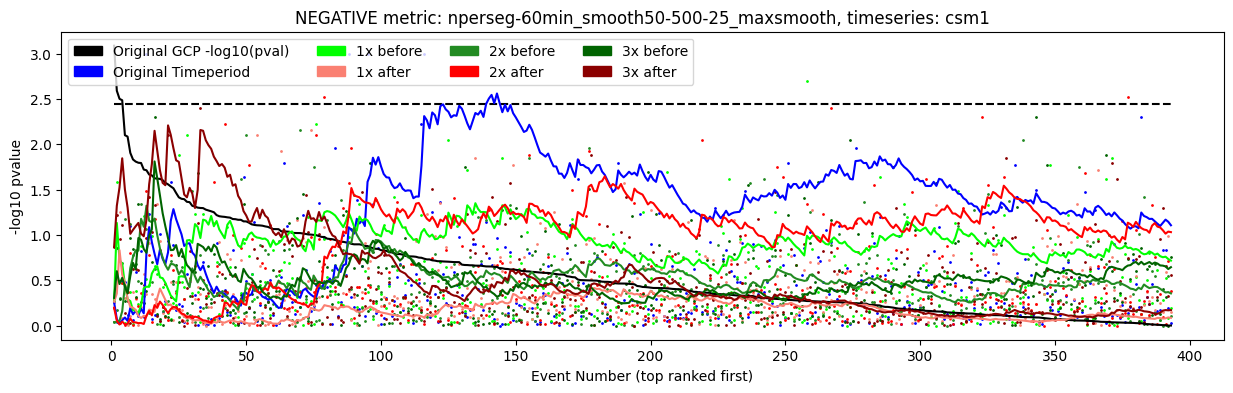

NEGATIVE nperseg-NA_smooth100-150-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8972205558888222
Rankbias p-value: Original Timeperiod pval: 0.7998672452460667
meta-analysis p-value: 1x before pval: 0.15996800639872025
Rankbias p-value: 1x before pval: 0.018244846873497977
meta-analysis p-value: 1x after pval: 0.6820635872825436
Rankbias p-value: 1x after pval: 0.705407699874281
meta-analysis p-value: 2x before pval: 0.05118976204759047
Rankbias p-value: 2x before pval: 0.22688004982194931
meta-analysis p-value: 2x after pval: 0.05578884223155369
Rankbias p-value: 2x after pval: 0.06319126144598868
meta-analysis p-value: 3x before pval: 0.585882823435313
Rankbias p-value: 3x before pval: 0.7383970320581046
meta-analysis p-value: 3x after pval: 0.2995400919816037
Rankbias p-value: 3x after pval: 0.02846866453634312


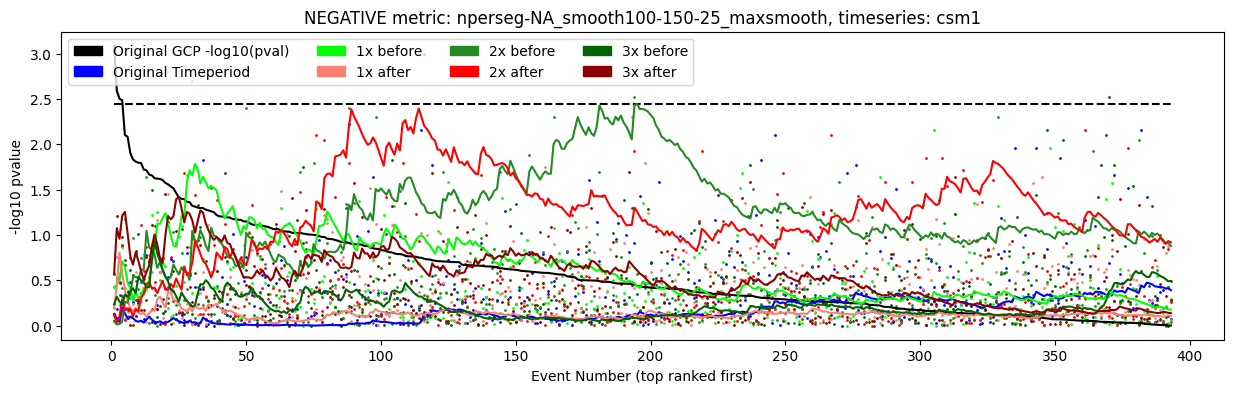

NEGATIVE nperseg-60min_smooth100-150-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.264747050589882
Rankbias p-value: Original Timeperiod pval: 0.2531858540767338
meta-analysis p-value: 1x before pval: 0.11457708458308338
Rankbias p-value: 1x before pval: 0.03729510441488718
meta-analysis p-value: 1x after pval: 0.8544291141771646
Rankbias p-value: 1x after pval: 0.5228091885480401
meta-analysis p-value: 2x before pval: 0.503499300139972
Rankbias p-value: 2x before pval: 0.6134471302969525
meta-analysis p-value: 2x after pval: 0.2625474905018996
Rankbias p-value: 2x after pval: 0.05681671562441288
meta-analysis p-value: 3x before pval: 0.08298340331933614
Rankbias p-value: 3x before pval: 0.9018879099323371
meta-analysis p-value: 3x after pval: 0.22195560887822435
Rankbias p-value: 3x after pval: 0.16122800373131263


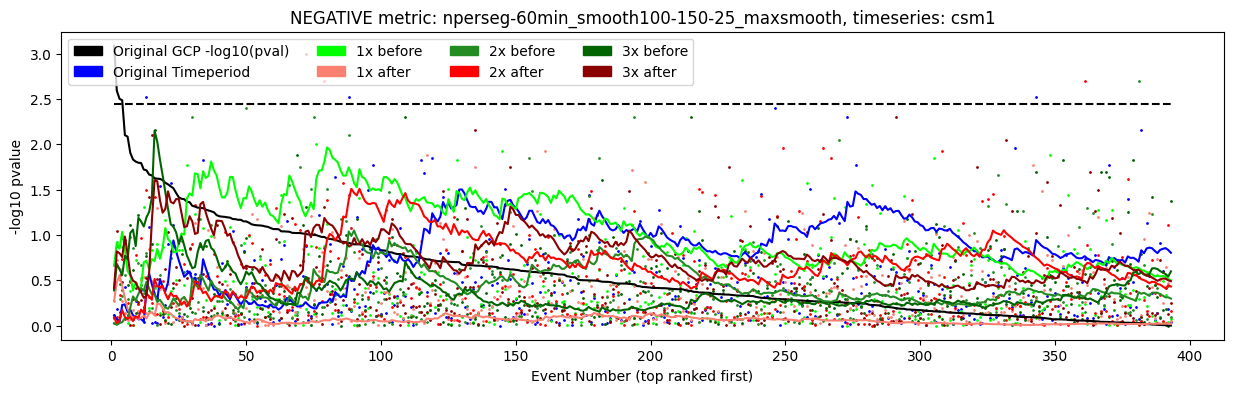

NEGATIVE nperseg-NA_smooth125-125-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8554289142171566
Rankbias p-value: Original Timeperiod pval: 0.4884994948782802
meta-analysis p-value: 1x before pval: 0.1271745650869826
Rankbias p-value: 1x before pval: 0.15624323365824316
meta-analysis p-value: 1x after pval: 0.7092581483703261
Rankbias p-value: 1x after pval: 0.40470867926461
meta-analysis p-value: 2x before pval: 0.17276544691061788
Rankbias p-value: 2x before pval: 0.3392087416636216
meta-analysis p-value: 2x after pval: 0.09858028394321136
Rankbias p-value: 2x after pval: 0.1411868120611614
meta-analysis p-value: 3x before pval: 0.5720855828834233
Rankbias p-value: 3x before pval: 0.929087986927022
meta-analysis p-value: 3x after pval: 0.47730453909218157
Rankbias p-value: 3x after pval: 0.03227090855473871


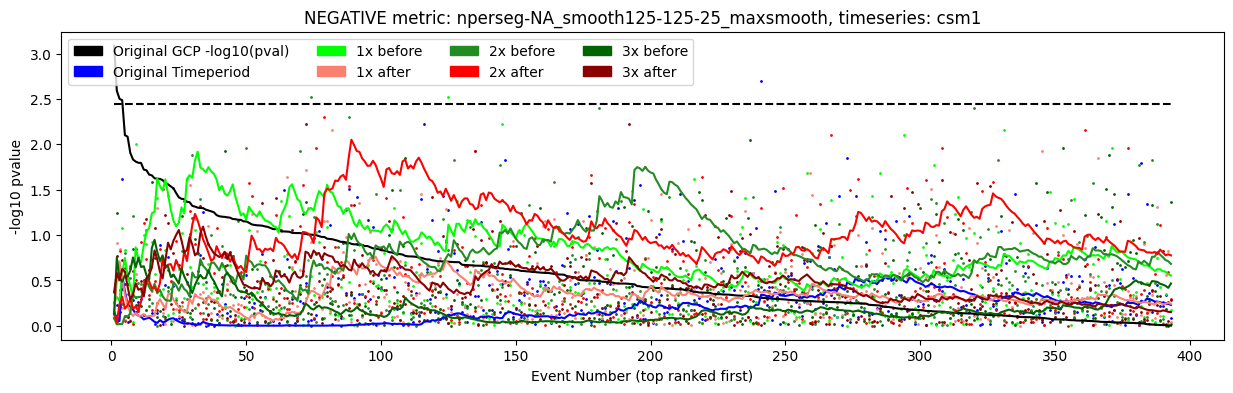

NEGATIVE nperseg-60min_smooth125-125-25_maxsmooth
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5318936212757449
Rankbias p-value: Original Timeperiod pval: 0.1988536733834274
meta-analysis p-value: 1x before pval: 0.1759648070385923
Rankbias p-value: 1x before pval: 0.17703444577513922
meta-analysis p-value: 1x after pval: 0.9378124375124975
Rankbias p-value: 1x after pval: 0.42647911234403524
meta-analysis p-value: 2x before pval: 0.6622675464907019
Rankbias p-value: 2x before pval: 0.3786956427258784
meta-analysis p-value: 2x after pval: 0.5870825834833033
Rankbias p-value: 2x after pval: 0.18449878714108642
meta-analysis p-value: 3x before pval: 0.2495500899820036
Rankbias p-value: 3x before pval: 0.9466482528750941
meta-analysis p-value: 3x after pval: 0.28534293141371725
Rankbias p-value: 3x after pval: 0.15900012436700922


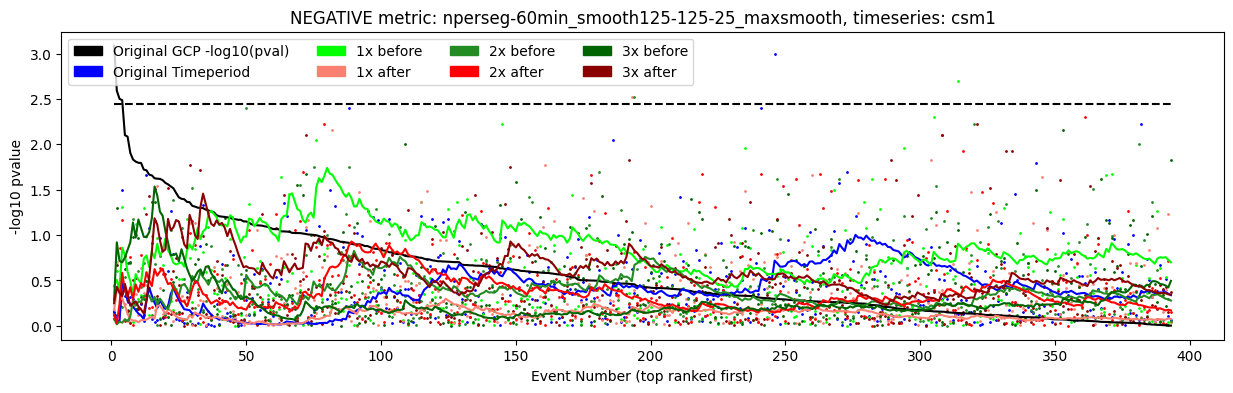

In [16]:
spannames = ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after', '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon', 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

for signalname, pvals in [('csm1', csm1_psanalysis),
                          #('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  npersegvals = ['NA', '60min']
  for metricname in ( ['nperseg-'+x+'_entropy' for x in npersegvals]+
                      ['nperseg-'+x+'_maxautocorr' for x in npersegvals]+
                      ['nperseg-'+x+'_ef' for x in npersegvals]+
                      ['nperseg-'+x+'_maxd' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth50-500-25_maxsmooth' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth100-150-25_maxsmooth' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth125-125-25_maxsmooth' for x in npersegvals]
                      ):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [('csm1', csm1_psanalysis),
                          #('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  npersegvals = ['NA', '60min']
  for metricname in ( ['nperseg-'+x+'_entropy' for x in npersegvals]+
                      ['nperseg-'+x+'_maxautocorr' for x in npersegvals]+
                      ['nperseg-'+x+'_ef' for x in npersegvals]+
                      ['nperseg-'+x+'_maxd' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth50-500-25_maxsmooth' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth100-150-25_maxsmooth' for x in npersegvals]+
                      ['nperseg-'+x+'_smooth125-125-25_maxsmooth' for x in npersegvals]
                      ):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [17]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:Original Timeperiod; signal:csm1; metric:nperseg-60min_smooth125-125-25_maxsmooth',
  0.0033993201359728054,
  0.6662667466506699),
 ('span:Original Timeperiod; signal:csm1; metric:nperseg-NA_smooth125-125-25_maxsmooth',
  0.004199160167966407,
  0.41151769646070785),
 ('span:Original Timeperiod; signal:csm1; metric:nperseg-60min_smooth100-150-25_maxsmooth',
  0.022795440911817632,
  1.4893021395720851),
 ('span:Original Timeperiod; signal:csm1; metric:nperseg-60min_ef',
  0.02559488102379524,
  1.2541491701659668),
 ('span:Original Timeperiod; signal:csm1; metric:nperseg-NA_smooth100-150-25_maxsmooth',
  0.03259348130373925,
  1.2776644671065784),
 ('span:Original Timeperiod; signal:csm1; metric:negative-nperseg-60min_smooth50-500-25_maxsmooth',
  0.03799240151969606,
  1.2410851163100711),
 ('span:1x before; signal:csm1; metric:negative-nperseg-NA_smooth50-500-25_maxsmooth',
  0.046390721855628876,
  1.2989402119576086),
 ('span:3x after; signal:csm1; metric:negative-nperseg-